In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from trainlib import lagndelay, scale, split
from scipy import stats
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error, r2_score



%matplotlib inline

In [3]:
def calculate(df_results):
    y_test = df_results['ground_truth'].values
    y_pred = df_results['predictions'].values
    # #RMSE
    # rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    # print('RMSE:', rmse, end="\t")
    # #MAE
    # mae = mean_absolute_error(y_test, y_pred)
    # print('MAE:', mae, end="\t")
    # #MSE
    # mse = mean_squared_error(y_test.reshape(-1), y_pred.reshape(-1))
    # print("MSE:", mse, end="\t")

    # PBIAS 계산
    diff = np.sum(y_pred - y_test)
    sum_observed = np.sum(y_test)
    pbias = (diff / sum_observed) * 100
    print('PBIAS:', pbias, end="\t")

    # NSE 계산
    diff_pred_obs = np.sum((y_pred - y_test) ** 2)
    diff_obs_mean = np.sum((y_test - np.mean(y_test)) ** 2)
    nse = 1 - (diff_pred_obs / diff_obs_mean)
    print('NSE:', nse, end="\t")
    # slope, intercept, r_value, p_value, std_err = stats.linregress(x=df_results['predictions'],y=df_results['ground_truth'])
    # print('R2 = ',r_value*r_value)

In [57]:
plt.rc('font', family='AppleGothic') 			## 이 두 줄을 
plt.rcParams['axes.unicode_minus'] = False  ## 추가해줍니다. 
# plt.rcParams["figure.figsize"] = (5,10)
# plt.rcParams['axes.grid'] = True


In [48]:
data_df = pd.read_csv("../data/data/합천_댐기상종합_전처리_scaled_flood.csv", index_col=0)
data_df.drop(['전일유입량', '강수량(mm)'], axis=1, inplace=True)
df2 = data_df.copy()
num_lags = 3 # number of lags and window lenghts for mean aggregation
delay = 1 # predict target five steps ahead
y = '당일유입량'
df_processed = lagndelay(num_lags, delay, df2, y)
df_train, df_test = split(0.8, df_processed)
h2o.init(ip="localhost", port=54323, nthreads=-1)
h2o.no_progress()
hf_train = h2o.H2OFrame(df_train)
hf_test = h2o.H2OFrame(df_test)
X = hf_train.columns
X.remove(y)
aml = H2OAutoML(max_models=10,
                seed = 42)
aml.train(x = X, 
          y = y,
          training_frame = hf_train,
          leaderboard_frame = hf_test)
# flood_lb = aml.leaderboard
# flood_leader_model = aml.leader
hf_test_predict = aml.predict(hf_test)

tt, df_test = split(0.8, data_df)


df_results_flood = pd.DataFrame()
df_results_flood['ground_truth'] = df_test[y].reset_index(drop=True)
df_results_flood['predictions'] = h2o.as_list(hf_test_predict,use_pandas=True)
df_results_flood.set_index(df_test.index.values, inplace=True)
df_results_flood.dropna(inplace=True)

calculate(df_results_flood)


Checking whether there is an H2O instance running at http://localhost:54323. connected.


H2O_cluster_uptime:,1 hour 14 mins
H2O_cluster_timezone:,Asia/Seoul
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.4
H2O_cluster_version_age:,1 month and 11 days
H2O_cluster_name:,H2O_from_python_jewel_6o7mc4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6.125 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


PBIAS: -0.5473726194830674	NSE: 0.4296679159995036	

In [ ]:
2 PBIAS: -1.1349154870055462	NSE: 0.4293656873267393	
3 PBIAS: -0.5473726194830674	NSE: 0.4296679159995036	
4 PBIAS: 4.967556583627046	NSE: 0.3936647282653891	

5 PBIAS: 1.5833719483730149	NSE: 0.1708731137725238

In [47]:
aml.leader

key,value
Stacking strategy,cross_validation
Number of base models (used / total),4/5
# GBM base models (used / total),1/1
# XGBoost base models (used / total),1/1
# DRF base models (used / total),2/2
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


In [20]:
aml.leader.explain

<bound method explain of H2OGradientBoostingEstimator({'parms': {'model_id': {'__meta': {'schema_version': 3, 'schema_name': 'ModelParameterSchemaV3', 'schema_type': 'Iced'}, 'name': 'model_id', 'label': 'model_id', 'help': 'Destination id for this model; auto-generated if not specified.', 'required': False, 'type': 'Key<Model>', 'default_value': None, 'actual_value': {'__meta': {'schema_version': 3, 'schema_name': 'ModelKeyV3', 'schema_type': 'Key<Model>'}, 'name': 'GBM_4_AutoML_8_20230608_222028', 'type': 'Key<Model>', 'URL': '/3/Models/GBM_4_AutoML_8_20230608_222028'}, 'input_value': None, 'level': 'critical', 'values': [], 'is_member_of_frames': [], 'is_mutually_exclusive_with': [], 'gridable': False}, 'training_frame': {'__meta': {'schema_version': 3, 'schema_name': 'ModelParameterSchemaV3', 'schema_type': 'Iced'}, 'name': 'training_frame', 'label': 'training_frame', 'help': 'Id of the training data frame.', 'required': False, 'type': 'Key<Frame>', 'default_value': None, 'actual_v

In [78]:
data_df = pd.read_csv("../data/data/합천_댐기상종합_전처리_scaled_notflood.csv", index_col=0)
data_df.drop(['전일유입량', '강수량(mm)'], axis=1, inplace=True)

df2 = data_df.copy()
num_lags = 10 # number of lags and window lenghts for mean aggregation
delay = 1 # predict target five steps ahead
y = '당일유입량'
df_processed = lagndelay(num_lags, delay, df2, y)
df_train, df_test = split(0.8, df_processed)
h2o.init(ip="localhost", port=54323, nthreads=-1)
h2o.no_progress()
hf_train = h2o.H2OFrame(df_train)
hf_test = h2o.H2OFrame(df_test)
X = hf_train.columns
X.remove(y)
naml = H2OAutoML(max_models=10,
                seed = 42)
naml.train(x = X, 
          y = y,
          training_frame = hf_train,
          leaderboard_frame = hf_test)
# non_lb = aml.leaderboard
# non_leader_model = aml.leader
hf_test_predict = naml.predict(hf_test)
tt, df_test = split(0.8, data_df)

df_results_nonflood = pd.DataFrame()
df_results_nonflood['ground_truth'] = df_test[y].reset_index(drop=True)
df_results_nonflood['predictions'] = h2o.as_list(hf_test_predict,use_pandas=True)
df_results_nonflood.set_index(df_test.index.values, inplace=True)
df_results_nonflood.dropna(inplace=True)

calculate(df_results_nonflood)

Checking whether there is an H2O instance running at http://localhost:54323. connected.


/Users/jewel/Documents/2023_1학기/정미나_데이터사이언스캡스톤/code/2023-01-DSCapstone-InflowPrediction/code/models/trainlib.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column + '_avg_window_length' + str(lag+1)] = df[column].shift(-1-(
/Users/jewel/Documents/2023_1학기/정미나_데이터사이언스캡스톤/code/2023-01-DSCapstone-InflowPrediction/code/models/trainlib.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column + '_lag' + str(lag)] = df[column].shift(lag*-1-(delay-1))
/Users/jewel/Documents/2023_1학

H2O_cluster_uptime:,1 hour 49 mins
H2O_cluster_timezone:,Asia/Seoul
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.4
H2O_cluster_version_age:,1 month and 11 days
H2O_cluster_name:,H2O_from_python_jewel_6o7mc4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6.068 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


PBIAS: 33.645177522084275	NSE: 0.1222223951983229	

5 PBIAS: 3.3560336163661346	NSE: 0.3118905007473032	
7 PBIAS: 29.204421181488726	NSE: 0.36168145104661686	
10 PBIAS: 33.645177522084275	NSE: 0.1222223951983229	


In [38]:
naml

key,value
Stacking strategy,cross_validation
Number of base models (used / total),4/5
# GBM base models (used / total),1/1
# XGBoost base models (used / total),1/1
# DRF base models (used / total),2/2
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


In [59]:
df_results = pd.concat([df_results_nonflood, df_results_flood])
df_results.dropna(axis=0, inplace=True)

df_results.sort_index(inplace=True)
df_results.head()
df_results.index = pd.to_datetime(df_results.index)

In [55]:
calculate(df_results)

PBIAS: 0.7187491993641514	NSE: 0.44836120004029767	

2-5 PBIAS: 0.3217836889320582	NSE: 0.44812278717569654	
3-5 PBIAS: 0.7187491993641514	NSE: 0.44836120004029767
5-5 PBIAS: 2.1585100619460897	NSE: 0.24436562838360754	

3-4 PBIAS: 2.057861677808676	NSE: 0.45300950357896064	




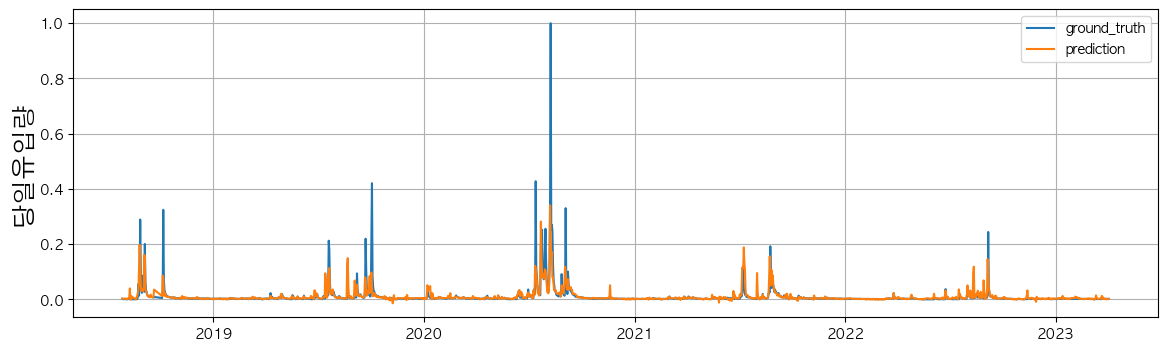

In [60]:
plt.rcParams["figure.figsize"] = (14,4)
plt.plot(df_results['ground_truth'])
plt.plot(df_results['predictions'])
plt.ylabel(y,fontsize=18)
plt.legend(['ground_truth','prediction'])
plt.show()

In [66]:
df_results_flood

,ground_truth,predictions
2018-07-27,0.001897,0.002442
2018-07-28,0.000896,0.002133
2018-07-29,0.000053,0.001538
2018-07-30,0.001897,0.002269
2018-07-31,0.000896,0.002411
...,...,...
2022-09-15,0.005165,0.004715
2022-09-16,0.005271,0.002781
2022-09-17,0.006219,0.010564
2022-09-18,0.005903,0.004138


In [67]:
df_results_flood.index = pd.to_datetime(df_results_flood.index)

In [75]:

def plott(df_results):
    plt.rcParams["figure.figsize"] = (12,6)
    plt.plot(df_results['ground_truth'])
    plt.plot(df_results['predictions'])
    plt.ylabel(y,fontsize=18)
    plt.legend(['ground_truth','prediction'])
    plt.show()


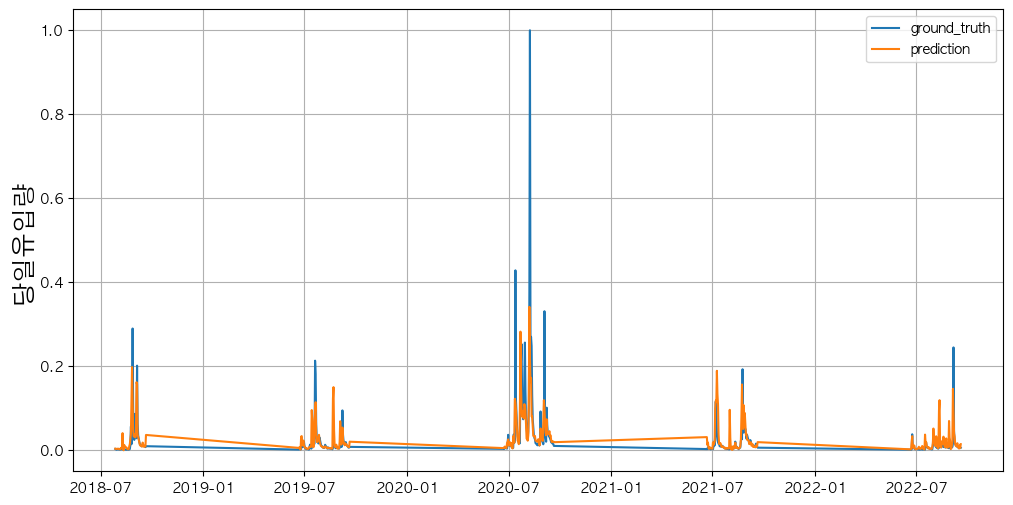

In [76]:
plott(df_results_flood)

In [73]:
df_results_nonflood.index = pd.to_datetime(df_results_nonflood.index)


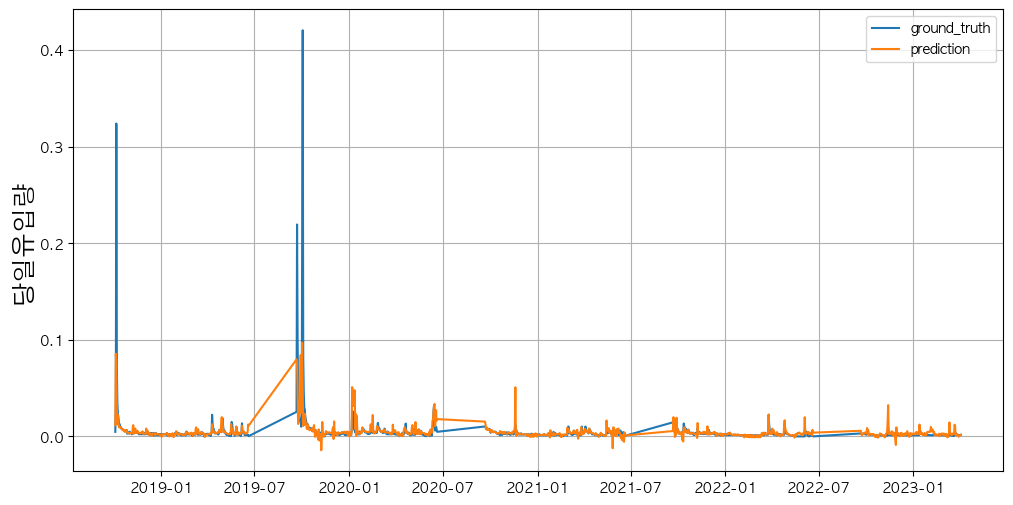

In [77]:
plott(df_results_nonflood)


In [ ]:
data_df = pd.read_csv("../data/data/합천_댐기상종합_전처리.csv", index_col=0)
data_df.drop(['전일유입량', '강수량(mm)'], axis=1, inplace=True)

df2 = data_df.copy()
num_lags = 3 # number of lags and window lenghts for mean aggregation
delay = 1 # predict target five steps ahead
y = '당일유입량'
df_processed = lagndelay(num_lags, delay, df2, y)
df_train, df_test = split(0.8, df_processed)
h2o.init(ip="localhost", port=54323, nthreads=-1)
h2o.no_progress()
hf_train = h2o.H2OFrame(df_train)
hf_test = h2o.H2OFrame(df_test)
X = hf_train.columns
X.remove(y)
aml = H2OAutoML(max_models=10,
                seed = 42)
aml.train(x = X, 
          y = y,
          training_frame = hf_train,
          leaderboard_frame = hf_test)
# flood_lb = aml.leaderboard
# flood_leader_model = aml.leader
hf_test_predict = aml.predict(hf_test)

tt, df_test = split(0.8, data_df)


df_results_flood = pd.DataFrame()
df_results_flood['ground_truth'] = df_test[y].reset_index(drop=True)
df_results_flood['predictions'] = h2o.as_list(hf_test_predict,use_pandas=True)
df_results_flood.set_index(df_test.index.values, inplace=True)
df_results_flood.dropna(inplace=True)

calculate(df_results_flood)
